In [ ]:
# STEP 1 — Install & Import

!pip install -q scikit-learn matplotlib pandas seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

sns.set(style="whitegrid")


In [ ]:
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print(" Data Loaded Successfully!")
print("Shape:", df.shape)
df.head()


Saving student_stress_dataset_final.csv to student_stress_dataset_final (1).csv
 Data Loaded Successfully!
Shape: (50, 14)


,Course,Age,Gender,Year of study,Study hours per day,Sleep hours,Physically active,Social support,Academic pressure,Financial pressure,Family pressure,Health issues,Screen Time in hours,Overall stress
0,MBA,19,Male,2 nd year,4 and above,6 hrs,Moderate,5,1,2,2,Yes,6,3
1,MBBS,18,Male,1 st year,2 to 3hrs,8 hrs,More active,4,2,2,3,No,2,5
2,MBBS,18,Female,2 nd year,4 and above,9 hrs,Moderate,5,5,3,3,Yes,5,2
3,MBA,24,Female,5 th year,1 to 2hrs,8 hrs,Normal,4,4,1,1,No,3,5
4,BTech,24,Male,4 th year,1 to 2hrs,8 to 9 hrs,Moderate,5,5,5,4,No,3,2


In [ ]:
import re

# Convert range-like strings (e.g., '2-4 hrs') into numeric midpoints
def parse_range_to_midpoint(s):
    if pd.isna(s): return np.nan
    s = str(s).lower().replace('hrs','').replace('hr','').strip()
    if 'and above' in s:
        num = re.findall(r'\d+', s)
        return float(num[0]) + 1 if num else np.nan
    if 'to' in s or '-' in s:
        nums = re.findall(r'\d+', s)
        return (float(nums[0]) + float(nums[1])) / 2 if len(nums) >= 2 else np.nan
    nums = re.findall(r'\d+', s)
    return float(nums[0]) if nums else np.nan

# Apply cleaning
df['Study_hours'] = df['Study hours per day'].astype(str).apply(lambda x: parse_range_to_midpoint(x.replace('-', ' to ')))
df['Sleep_hours'] = df['Sleep hours'].astype(str).apply(lambda x: parse_range_to_midpoint(x.replace('-', ' to ')))

# Map categorical values
activity_map = {'Normal':1,'Moderate':2,'Active':3,'More active':4,
                'normal':1,'moderate':2,'active':3,'more active':4}
df['Physically_active'] = df['Physically active'].astype(str).map(activity_map)

df['Health_issues'] = df['Health issues'].astype(str).str.lower().map({'yes':1,'no':0})
df['Screen_Time'] = pd.to_numeric(df['Screen Time in hours'], errors='coerce')

# Convert stress-related columns to numeric
for col in ['Social support','Academic pressure','Financial pressure','Family pressure','Overall stress']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing numeric values with median
df.fillna(df.median(numeric_only=True), inplace=True)

print("Data cleaned successfully!")
df.head()


Data cleaned successfully!


,Course,Age,Gender,Year of study,Study hours per day,Sleep hours,Physically active,Social support,Academic pressure,Financial pressure,Family pressure,Health issues,Screen Time in hours,Overall stress,Study_hours,Sleep_hours,Physically_active,Health_issues,Screen_Time
0,MBA,19,Male,2 nd year,4 and above,6 hrs,Moderate,5,1,2,2,Yes,6,3,5.0,6.0,2,1,6
1,MBBS,18,Male,1 st year,2 to 3hrs,8 hrs,More active,4,2,2,3,No,2,5,2.5,8.0,4,0,2
2,MBBS,18,Female,2 nd year,4 and above,9 hrs,Moderate,5,5,3,3,Yes,5,2,5.0,9.0,2,1,5
3,MBA,24,Female,5 th year,1 to 2hrs,8 hrs,Normal,4,4,1,1,No,3,5,1.5,8.0,1,0,3
4,BTech,24,Male,4 th year,1 to 2hrs,8 to 9 hrs,Moderate,5,5,5,4,No,3,2,1.5,8.5,2,0,3


In [ ]:
# Drop original text columns
df_encoded = df.drop(['Study hours per day', 'Sleep hours', 'Physically active', 'Health issues', 'Screen Time in hours'], axis=1)

# Define features (X) and target (y)
X = df_encoded.drop('Overall stress', axis=1)
y = df_encoded['Overall stress']

print("Feature encoding complete!")
print("Features shape:", X.shape)


Feature encoding complete!
Features shape: (50, 13)


In [ ]:


# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols.tolist())

X = X.drop(columns=non_numeric_cols)


# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for col in non_numeric_cols:
#     X[col] = le.fit_transform(X[col].astype(str))

print(" All non-numeric columns handled.")


Non-numeric columns: ['Course', 'Gender', 'Year of study']
 All non-numeric columns handled.


In [ ]:
print("Training feature columns used in model:")
print(list(X.columns))


Training feature columns used in model:
['Age', 'Social support', 'Academic pressure', 'Financial pressure', 'Family pressure', 'Study_hours', 'Sleep_hours', 'Physically_active', 'Health_issues', 'Screen_Time']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Data split and scaled successfully!")


 Data split and scaled successfully!


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    })

results_df = pd.DataFrame(results)
print("Model training completed!")
results_df


Model training completed!


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.3,0.28,0.3,0.247619
1,Random Forest,0.1,0.10,0.1,0.100000
2,SVM,0.3,0.28,0.3,0.247619


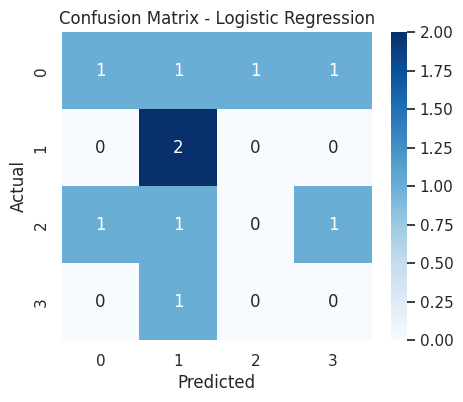

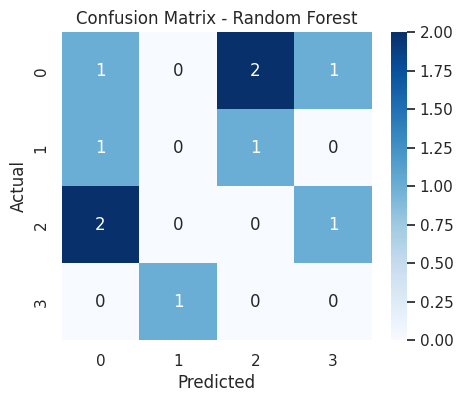

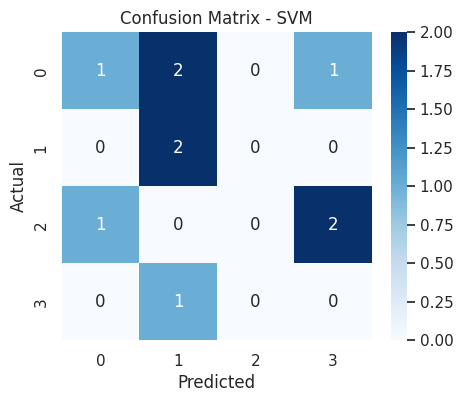

In [ ]:
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [ ]:
best_model_name = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]

joblib.dump(best_model, f'{best_model_name.replace(" ", "_").lower()}_model.pkl')
print(f" Best model ({best_model_name}) saved successfully!")


 Best model (Logistic Regression) saved successfully!


/tmp/ipython-input-2233184254.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')


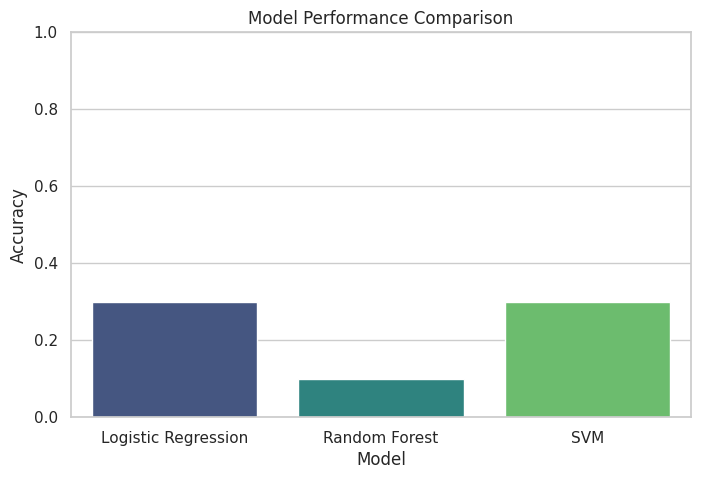

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
plt.title('Model Performance Comparison')
plt.ylim(0,1)
plt.show()


In [ ]:
from IPython.display import clear_output

def predict_stress_level():
    clear_output(wait=True)
    print("🧠 Student Stress Level Predictor\n")

    # Collect inputs in the same order as training features
    age = float(input("🎓 Age: "))
    social_support = float(input("👫 Social support (1–5): "))
    academic_pressure = float(input("📚 Academic pressure (1–5): "))
    financial_pressure = float(input("💰 Financial pressure (1–5): "))
    family_pressure = float(input("🏠 Family pressure (1–5): "))
    study_hours = float(input("📘 Study hours per day: "))
    sleep_hours = float(input("💤 Sleep hours per day: "))
    physically_active = int(input("🏃 Physical activity (1=Normal, 2=Moderate, 3=Active, 4=More Active): "))
    health_issues = int(input("⚕️ Health issues? (1=Yes, 0=No): "))
    screen_time = float(input("📱 Screen time (hours per day): "))

    # Put into DataFramer
    input_data = pd.DataFrame([[
        age, social_support, academic_pressure, financial_pressure,
        family_pressure, study_hours, sleep_hours,
        physically_active, health_issues, screen_time
    ]], columns=[
        'Age', 'Social support', 'Academic pressure', 'Financial pressure',
        'Family pressure', 'Study_hours', 'Sleep_hours',
        'Physically_active', 'Health_issues', 'Screen_Time'
    ])

    # Scale and predict
    input_scaled = scaler.transform(input_data)
    pred = best_model.predict(input_scaled)[0]
    prob = best_model.predict_proba(input_scaled).max() * 100

    print("\n🩺 Predicted Stress Level:", round(pred, 2))
    print(f"📊 Model Confidence: {prob:.2f}%")

# Run the function
predict_stress_level()


🧠 Student Stress Level Predictor

🎓 Age: 23
👫 Social support (1–5): 1
📚 Academic pressure (1–5): 5
💰 Financial pressure (1–5): 1
🏠 Family pressure (1–5): 1
📘 Study hours per day: 5
💤 Sleep hours per day: 6
🏃 Physical activity (1=Normal, 2=Moderate, 3=Active, 4=More Active): 1
⚕️ Health issues? (1=Yes, 0=No): 0
📱 Screen time (hours per day): 4

🩺 Predicted Stress Level: 5
📊 Model Confidence: 93.42%
